In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf



In [2]:
def find_dates(sids,model_cal):

	dates = sids.apply(lambda row : cf.datetime(calendar=model_cal,
									year=row.year,
									month=row.month,
									day=row.day,
									hour=row.hour
									), axis=1)
	return dates



In [3]:
# load dataset
# load data
def generate_annual_frequency(meta,rain,units_converter,future=False):
	
	boolean = meta.date != 0
	print(meta.date)

	meta = meta.loc[boolean]
	rain = rain[boolean ,:,:,:]
	new_boolean = np.mean(rain,axis=(1,2,3)) != 0
	print('bool',new_boolean.shape)
	meta = meta.loc[new_boolean]
	rain = rain[new_boolean,:,:,:]

	boolean_time = meta.hour.isin([0,6,12,18,24])
	meta = meta.loc[boolean_time]
	rain = rain[boolean_time,:,:,:]

	print('number of timepoints = ', meta.shape)
	sids = meta.sid
	sids_unique = sids.drop_duplicates()
	tracks_grouped = meta.groupby(meta.sid)

	daily_rains = []

	print('sids unique',sids_unique.shape)


	for sample in rain:
		# print(sample.shape)
		# date_for_rain = tracks_grouped.get_group(date)

		track_daily_rain = np.mean(sample)*units_converter # for cmip this is 24, for imerg it should be 8

		daily_rains.append(track_daily_rain)

		# # imerg is mm/hr sampled based on ibtracs which is 3 hourly positions
		# units_converter_imerg = 3

		# # mswep is total rain mm/3hr sampled based on ibtracs which is 3 hourly positions interpolated from 6 hourly
		# units_converter_mswep = 1

		# # cmip is mm/6hr sampled every 6 hours
		# units_converter_cmip = 4


	x = np.arange(-5, 300, 5)
	y = np.histogram(daily_rains,bins = x)[0]

	print(y)
	window_size = 5
	smoothed_frequencies = np.convolve(y, np.ones(window_size) / window_size, mode='same')
	y = smoothed_frequencies
	y[0] = 1
	# y[y==0] = 1
	return y,x[1:]




In [4]:
def calc_nyears(meta):
	nyears = int(meta.year[len(meta.year)-1] - meta.year[0] + 1)
	return nyears

In [5]:
def lookup(row,cal,future=False):
	# date = cf.datetime(calendar=cal,
	# 				year=row.year,
	# 				month=row.month,
	# 				day=row.day,
	# 				hour=row.hour
	# 				)
	if future == False:
		yr1 = 2000
		yr2 = 2015
	elif future == 'highresmip':
		yr1 = 2035
		yr2 = 2049
	else:
		yr1 = 2085
		yr2 = 2099
	if row.year not in range(yr1,yr2):
		return 0
	else:
		date = cf.datetime(calendar=cal,
						year=row.year,
						month=row.month,
						day=row.day,
						)

	# date = pd.to_datetime('year' : row.year, 'month' : row.month, 'day' = row.day)
	return date

def lookup_ibtracs(row,tracks):
	# tracks = pd.read_csv('/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv',
	# 					usecols=['SID','LAT','LON','BASIN','NAME','SEASON', 'NATURE','ISO_TIME','USA_SSHS'],
	# 					parse_dates = ['ISO_TIME'],keep_default_na=False)
	boolean = (tracks.SID == row.sid) & (tracks.LAT == row.centre_lat) & (tracks.LON == row.centre_lon)
	time =  pd.to_datetime(tracks.loc[boolean].ISO_TIME)
	if list(time) == []:
		print('no',flush=True)
		date = cf.datetime(calendar='gregorian',
						year=1978,
						month=1,
						day=1,
						hour=0
						)
		return date
	else:
		time =  time.iloc[0]
		date = cf.datetime(calendar='gregorian',
						year=time.year,
						month=time.month,
						day=time.day,
						)
	return date

def find_dates_mswep(meta):
	dates = meta.apply(lookup, axis=1)
	return dates

def find_dates(meta,calendar,future):
	dates = meta.apply(lookup, cal = calendar,future=future, axis=1)
	return dates

def find_dates_ibtracs(meta):
	tracks = pd.read_csv('/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv',
						usecols=['SID','LAT','LON','BASIN','NAME','SEASON', 'NATURE','ISO_TIME','USA_SSHS'],
						parse_dates = ['ISO_TIME'],keep_default_na=False)
	dates = meta.apply(lookup_ibtracs, tracks= tracks, axis=1)
	# dates = meta.apply(lookup_ibtracs, axis=1)
	return dates

In [6]:
# load current 1D dataset
real,inputs,pred_scalar,meta = load_tc_data(set='validation',results='ke_tracks')
meta_scalar = pd.read_csv('/user/work/al18709/tc_data_mswep_40/scalar_wgan_valid_meta_with_dates.csv')
new_dates = [pd.to_datetime(str(date)) for date in meta_scalar.date]
meta_scalar['hour'] = pd.DataFrame({'dates':new_dates})['dates'].dt.hour


In [7]:
# # load original 2D WGAN
real_2,inputs_2,pred_2,meta_2,imput_og,pred_og,meta_og = load_tc_data(set='validation',results='kh_tracks')
real_og_x,_,_,_,_,_,pred_og_x,meta_og_x = load_tc_data(set='extreme_test',results='test')
meta_og = pd.read_csv('/user/work/al18709/tc_data_mswep_40/valid_meta.csv')
meta_og = pd.read_csv('/user/work/al18709/tc_data_mswep_40/original_wgan_valid_meta_with_dates.csv')
new_dates = [pd.to_datetime(str(date)) for date in meta_og.date]
meta_og['hour'] = pd.DataFrame({'dates':new_dates})['dates'].dt.hour


In [8]:
print(pd.DataFrame({'dates':new_dates})['dates'].dt.hour)

0        12
1        12
2        12
3        12
4        15
         ..
16248     9
16249     9
16250     9
16251     9
16252     9
Name: dates, Length: 16253, dtype: int32


In [9]:
# load imerg
imerg_rain = np.load('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_rain_NH.npy')
imerg_lats = np.load('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_lats_NH.npy')
imerg_lons = np.load('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_lons_NH.npy')
imerg_sids = pd.read_csv('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_sid_NH.csv')
print(imerg_sids.sid.shape)
meta_imerg = pd.DataFrame({'sid':imerg_sids.sid ,'centre_lat':imerg_lats[:,4], 'centre_lon':imerg_lons[:,4],'date':find_dates(imerg_sids,calendar='julian',future=False), 'hour':imerg_sids.hour})

(22142,)


In [10]:
# load MSWEP
# load mswep
# mswep_rain = np.load('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_rain_NH.npy')
# mswep_lats = np.load('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_lats_NH.npy')
# mswep_lons = np.load('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_lons_NH.npy')
# mswep_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_sid_NH.csv')
# print(mswep_sids.sid.shape)
# meta_mswep = pd.DataFrame({'sid':mswep_sids.sid ,'centre_lat':mswep_lats[:,4], 'centre_lon':mswep_lons[:,4],'date':find_dates(mswep_sids,calendar='standard'), 'hour':mswep_sids.hour})

mswep_rain = np.load('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_rain_tcs_and_ts.npy')
mswep_lats = np.load('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_lats_tcs_and_ts.npy')
mswep_lons = np.load('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_lons_tcs_and_ts.npy')
mswep_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_sid_tcs_and_ts.csv')
print(mswep_sids.sid.shape)
print(mswep_sids.year)
idx = mswep_sids.year >= 2000
mswep_rain = mswep_rain[idx]
mswep_lats = mswep_lats[idx]
mswep_lons = mswep_lons[idx]
mswep_sids = mswep_sids[mswep_sids.year >= 2000].reset_index()
meta_mswep = pd.DataFrame({'sid':mswep_sids.sid ,'centre_lat':mswep_lats[:,4], 'centre_lon':mswep_lons[:,4],'date':find_dates(mswep_sids,calendar='standard',future=False),'hour':mswep_sids.hour})

(43955,)
0        1999
1        1999
2        1999
3        1999
4        1999
         ... 
43950    2014
43951    2014
43952    2014
43953    2014
43954    2014
Name: year, Length: 43955, dtype: int64


In [11]:
# load HighResMIP CMCC-CM2-VHR4 historical NH
CMCC_hist_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_rain_NH.npy')
CMCC_hist_NH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_lats_NH.npy')
CMCC_hist_NH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_lons_NH.npy')
CMCC_hist_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_sid_NH.csv')
print(CMCC_hist_NH_sids.sid.shape)
indices = (CMCC_hist_NH_sids['year'] >= 2000) & (CMCC_hist_NH_sids['year'] <= 2014)
CMCC_hist_NH_sids = CMCC_hist_NH_sids[indices].reset_index()
CMCC_hist_NH_rain = CMCC_hist_NH_rain[indices]
CMCC_hist_NH_lats = CMCC_hist_NH_lats[indices]
CMCC_hist_NH_lons = CMCC_hist_NH_lons[indices]
meta_CMCC_hist_NH = pd.DataFrame({'sid':CMCC_hist_NH_sids.sid ,'centre_lat':CMCC_hist_NH_lats[:,4], 'centre_lon':CMCC_hist_NH_lons[:,4], 'date':find_dates(CMCC_hist_NH_sids,'365_day',False), 'hour':CMCC_hist_NH_sids.hour})

# load HighResMIP CMCC-CM2-VHR4 historical SH
CMCC_hist_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_rain_SH.npy')
CMCC_hist_SH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_lats_SH.npy')
CMCC_hist_SH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_lons_SH.npy')
CMCC_hist_SH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_sid_SH.csv')
print(CMCC_hist_SH_sids.sid.shape)
indices = (CMCC_hist_SH_sids['year'] >= 2000) & (CMCC_hist_SH_sids['year'] <= 2014)
CMCC_hist_SH_sids = CMCC_hist_SH_sids[indices].reset_index()
CMCC_hist_SH_rain = CMCC_hist_SH_rain[indices]
CMCC_hist_SH_lats = CMCC_hist_SH_lats[indices]
CMCC_hist_SH_lons = CMCC_hist_SH_lons[indices]
meta_CMCC_hist_SH = pd.DataFrame({'sid':CMCC_hist_SH_sids.sid ,'centre_lat':CMCC_hist_SH_lats[:,4], 'centre_lon':CMCC_hist_SH_lons[:,4], 'date':find_dates(CMCC_hist_SH_sids,'365_day',False), 'hour':CMCC_hist_SH_sids.hour})

# load HighResMIP EC-EARTH-3P-HR  historical NH
ecearthhr_hist_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_rain_NH.npy')
ecearthhr_hist_NH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_lats_NH.npy')
ecearthhr_hist_NH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_lons_NH.npy')
ecearthhr_hist_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_sid_NH.csv')
print(ecearthhr_hist_NH_sids.sid.shape)
indices = (ecearthhr_hist_NH_sids['year'] >= 2000) & (ecearthhr_hist_NH_sids['year'] <= 2014)
ecearthhr_hist_NH_sids = ecearthhr_hist_NH_sids[indices].reset_index()
ecearthhr_hist_NH_rain = ecearthhr_hist_NH_rain[indices]
ecearthhr_hist_NH_lats = ecearthhr_hist_NH_lats[indices]
ecearthhr_hist_NH_lons = ecearthhr_hist_NH_lons[indices]
meta_ecearthhr_hist_NH = pd.DataFrame({'sid':ecearthhr_hist_NH_sids.sid ,'centre_lat':ecearthhr_hist_NH_lats[:,4], 'centre_lon':ecearthhr_hist_NH_lons[:,4], 'year':ecearthhr_hist_NH_sids.year, 'hour':ecearthhr_hist_NH_sids.hour})

# load HighResMIP EC-EARTH-3P-HR historical SH
ecearthhr_hist_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_rain_SH.npy')
ecearthhr_hist_SH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_lats_SH.npy')
ecearthhr_hist_SH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_lons_SH.npy')
ecearthhr_hist_SH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_sid_SH.csv')
print(ecearthhr_hist_SH_sids.sid.shape)
indices = (ecearthhr_hist_SH_sids['year'] >= 2000) & (ecearthhr_hist_SH_sids['year'] <= 2014)
ecearthhr_hist_SH_sids = ecearthhr_hist_SH_sids[indices].reset_index()
ecearthhr_hist_SH_rain = ecearthhr_hist_SH_rain[indices]
ecearthhr_hist_SH_lats = ecearthhr_hist_SH_lats[indices]
ecearthhr_hist_SH_lons = ecearthhr_hist_SH_lons[indices]
meta_ecearthhr_hist_SH = pd.DataFrame({'sid':ecearthhr_hist_SH_sids.sid ,'centre_lat':ecearthhr_hist_SH_lats[:,4], 'centre_lon':ecearthhr_hist_SH_lons[:,4], 'year':ecearthhr_hist_SH_sids.year, 'hour':ecearthhr_hist_SH_sids.hour})

# load HighResMIP HadGEM3-GC31-HM   historical NH
hadgem_hist_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_rain_NH.npy')
hadgem_hist_NH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_lats_NH.npy')
hadgem_hist_NH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_lons_NH.npy')
hadgem_hist_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_sid_NH.csv')
print(hadgem_hist_NH_sids.sid.shape)
indices = (hadgem_hist_NH_sids['year'] >= 2000) & (hadgem_hist_NH_sids['year'] <= 2014)
hadgem_hist_NH_sids = hadgem_hist_NH_sids[indices].reset_index()
hadgem_hist_NH_rain = hadgem_hist_NH_rain[indices]
hadgem_hist_NH_lats = hadgem_hist_NH_lats[indices]
hadgem_hist_NH_lons = hadgem_hist_NH_lons[indices]
meta_hadgem_hist_NH = pd.DataFrame({'sid':hadgem_hist_NH_sids.sid ,'centre_lat':hadgem_hist_NH_lats[:,4], 'centre_lon':hadgem_hist_NH_lons[:,4],'date':find_dates(hadgem_hist_NH_sids,'360_day',False), 'hour':hadgem_hist_NH_sids.hour})

# # load HighResMIP HadGEM3-GC31-HM  historical SH
hadgem_hist_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_rain_SH.npy')
hadgem_hist_SH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_lats_SH.npy')
hadgem_hist_SH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_lons_SH.npy')
hadgem_hist_SH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_sid_SH.csv')
print(hadgem_hist_SH_sids.sid.shape)
indices = (hadgem_hist_SH_sids['year'] >= 2000) & (hadgem_hist_SH_sids['year'] <= 2014)
hadgem_hist_SH_sids = hadgem_hist_SH_sids[indices].reset_index()
hadgem_hist_SH_rain = hadgem_hist_SH_rain[indices]
hadgem_hist_SH_lats = hadgem_hist_SH_lats[indices]
hadgem_hist_SH_lons = hadgem_hist_SH_lons[indices]
meta_hadgem_hist_SH = pd.DataFrame({'sid':hadgem_hist_SH_sids.sid ,'centre_lat':hadgem_hist_SH_lats[:,4], 'centre_lon':hadgem_hist_SH_lons[:,4], 'date':find_dates(hadgem_hist_SH_sids,'360_day',False), 'hour':hadgem_hist_SH_sids.hour})


(5236,)
(2366,)
(131,)
(62,)
(852,)
(195,)


In [12]:
# load CMIP6 historical dataset 
miroc6_hist_rain = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_rain_NH.npy')
miroc6_hist_lats = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_lats_NH.npy')
miroc6_hist_lons = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_lons_NH.npy')
miroc6_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_sid_NH.csv')
indices = (miroc6_hist_sids['year'] >= 2000) & (miroc6_hist_sids['year'] <= 2014)
miroc6_hist_sids = miroc6_hist_sids[indices].reset_index()
miroc6_hist_rain = miroc6_hist_rain[indices]
miroc6_hist_lats = miroc6_hist_lats[indices]
miroc6_hist_lons = miroc6_hist_lons[indices]
meta_miroc6_hist = pd.DataFrame({'sid':miroc6_hist_sids.sid ,'centre_lat':miroc6_hist_lats[:,4], 'centre_lon':miroc6_hist_lons[:,4], 'date':find_dates(miroc6_hist_sids,'gregorian',False), 'hour':miroc6_hist_sids.hour})

miroc6_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_rain_SH.npy')
miroc6_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_lats_SH.npy')
miroc6_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_lons_SH.npy')
miroc6_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_sid_SH.csv')
indices = (miroc6_hist_sids_SH['year'] >= 2000) & (miroc6_hist_sids_SH['year'] <= 2014)
miroc6_hist_sids_SH = miroc6_hist_sids_SH[indices].reset_index()
miroc6_hist_rain_SH = miroc6_hist_rain_SH[indices]
miroc6_hist_lats_SH = miroc6_hist_lats_SH[indices]
miroc6_hist_lons_SH = miroc6_hist_lons_SH[indices]
meta_miroc6_hist_SH = pd.DataFrame({'sid':miroc6_hist_sids_SH.sid ,'centre_lat':miroc6_hist_lats_SH[:,4], 'centre_lon':miroc6_hist_lons_SH[:,4], 'date':find_dates(miroc6_hist_sids_SH,'gregorian',False), 'hour':miroc6_hist_sids_SH.hour})

# CMIP6 MPI-ESM1-2-LR
mpi_hist_rain = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_rain_NH.npy')
mpi_hist_lats = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_lats_NH.npy')
mpi_hist_lons = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_lons_NH.npy')
mpi_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_sid_NH.csv')
indices = (mpi_hist_sids['year'] >= 2000) & (mpi_hist_sids['year'] <= 2014)
mpi_hist_sids = mpi_hist_sids[indices].reset_index()
mpi_hist_rain = mpi_hist_rain[indices]
mpi_hist_lats = mpi_hist_lats[indices]
mpi_hist_lons = mpi_hist_lons[indices]
meta_mpi_hist = pd.DataFrame({'sid':mpi_hist_sids.sid ,'centre_lat':mpi_hist_lats[:,4], 'centre_lon':mpi_hist_lons[:,4], 'date':find_dates(mpi_hist_sids,'proleptic_gregorian',False), 'hour':mpi_hist_sids.hour})

mpi_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_rain_SH.npy')
mpi_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_lats_SH.npy')
mpi_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_lons_SH.npy')
mpi_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_sid_SH.csv')
indices = (mpi_hist_sids_SH['year'] >= 2000) & (mpi_hist_sids_SH['year'] <= 2014)
mpi_hist_sids_SH = mpi_hist_sids_SH[indices].reset_index()
mpi_hist_rain_SH = mpi_hist_rain_SH[indices]
mpi_hist_lats_SH = mpi_hist_lats_SH[indices]
mpi_hist_lons_SH = mpi_hist_lons_SH[indices]
meta_mpi_hist_SH = pd.DataFrame({'sid':mpi_hist_sids_SH.sid ,'centre_lat':mpi_hist_lats_SH[:,4], 'centre_lon':mpi_hist_lons_SH[:,4], 'date':find_dates(mpi_hist_sids_SH,'proleptic_gregorian',False), 'hour':mpi_hist_sids_SH.hour})

# CMIP6 Noresm
noresm_hist_rain = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_rain_NH.npy')
noresm_hist_lats = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_lats_NH.npy')
noresm_hist_lons = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_lons_NH.npy')
noresm_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_sid_NH.csv')
indices = (noresm_hist_sids['year'] >= 2000) & (noresm_hist_sids['year'] <= 2014)
noresm_hist_sids = noresm_hist_sids[indices].reset_index()
noresm_hist_rain = noresm_hist_rain[indices]
noresm_hist_lats = noresm_hist_lats[indices]
noresm_hist_lons = noresm_hist_lons[indices]
meta_noresm_hist = pd.DataFrame({'sid':noresm_hist_sids.sid ,'centre_lat':noresm_hist_lats[:,4], 'centre_lon':noresm_hist_lons[:,4], 'date':find_dates(noresm_hist_sids,'noleap',False), 'hour':noresm_hist_sids.hour})

noresm_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_rain_SH.npy')
noresm_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_lats_SH.npy')
noresm_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_lons_SH.npy')
noresm_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_sid_SH.csv')
indices = (noresm_hist_sids_SH['year'] >= 2000) & (noresm_hist_sids_SH['year'] <= 2014)
noresm_hist_sids_SH = noresm_hist_sids_SH[indices].reset_index()
noresm_hist_rain_SH = noresm_hist_rain_SH[indices]
noresm_hist_lats_SH = noresm_hist_lats_SH[indices]
noresm_hist_lons_SH = noresm_hist_lons_SH[indices]
meta_noresm_hist_SH = pd.DataFrame({'sid':noresm_hist_sids_SH.sid ,'centre_lat':noresm_hist_lats_SH[:,4], 'centre_lon':noresm_hist_lons_SH[:,4], 'date':find_dates(noresm_hist_sids_SH,'noleap',False), 'hour':noresm_hist_sids_SH.hour})

# CMIP6 IPSL
ipsl_hist_rain = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_rain_NH.npy')
ipsl_hist_lats = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_lats_NH.npy')
ipsl_hist_lons = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_lons_NH.npy')
ipsl_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_sid_NH.csv')
indices = (ipsl_hist_sids['year'] >= 2000) & (ipsl_hist_sids['year'] <= 2014)
ipsl_hist_sids = ipsl_hist_sids[indices].reset_index()
ipsl_hist_rain = ipsl_hist_rain[indices]
ipsl_hist_lats = ipsl_hist_lats[indices]
ipsl_hist_lons = ipsl_hist_lons[indices]
meta_ipsl_hist = pd.DataFrame({'sid':ipsl_hist_sids.sid ,'centre_lat':ipsl_hist_lats[:,4], 'centre_lon':ipsl_hist_lons[:,4], 'date':find_dates(ipsl_hist_sids,'gregorian',False), 'hour':ipsl_hist_sids.hour})

ipsl_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_rain_SH.npy')
ipsl_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_lats_SH.npy')
ipsl_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_lons_SH.npy')
ipsl_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_sid_SH.csv')
indices = (ipsl_hist_sids_SH['year'] >= 2000) & (ipsl_hist_sids_SH['year'] <= 2014)
ipsl_hist_sids_SH = ipsl_hist_sids_SH[indices].reset_index()
ipsl_hist_rain_SH = ipsl_hist_rain_SH[indices]
ipsl_hist_lats_SH = ipsl_hist_lats_SH[indices]
ipsl_hist_lons_SH = ipsl_hist_lons_SH[indices]
meta_ipsl_hist_SH = pd.DataFrame({'sid':ipsl_hist_sids_SH.sid ,'centre_lat':ipsl_hist_lats_SH[:,4], 'centre_lon':ipsl_hist_lons_SH[:,4], 'date':find_dates(ipsl_hist_sids_SH,'gregorian',False), 'hour':ipsl_hist_sids_SH.hour})

# CMIP6 mri
mri_hist_rain = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_rain_NH.npy')
mri_hist_lats = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_lats_NH.npy')
mri_hist_lons = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_lons_NH.npy')
mri_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_sid_NH.csv')
indices = (mri_hist_sids['year'] >= 2000) & (mri_hist_sids['year'] <= 2014)
mri_hist_sids = mri_hist_sids[indices].reset_index()
mri_hist_rain = mri_hist_rain[indices]
mri_hist_lats = mri_hist_lats[indices]
mri_hist_lons = mri_hist_lons[indices]
meta_mri_hist = pd.DataFrame({'sid':mri_hist_sids.sid ,'centre_lat':mri_hist_lats[:,4], 'centre_lon':mri_hist_lons[:,4], 'date':find_dates(mri_hist_sids,'proleptic_gregorian',False), 'hour':mri_hist_sids.hour})

mri_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_rain_SH.npy')
mri_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_lats_SH.npy')
mri_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_lons_SH.npy')
mri_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_sid_SH.csv')
indices = (mri_hist_sids_SH['year'] >= 2000) & (mri_hist_sids_SH['year'] <= 2014)
mri_hist_sids_SH = mri_hist_sids_SH[indices].reset_index()
mri_hist_rain_SH = mri_hist_rain_SH[indices]
mri_hist_lats_SH = mri_hist_lats_SH[indices]
mri_hist_lons_SH = mri_hist_lons_SH[indices]
meta_mri_hist_SH = pd.DataFrame({'sid':mri_hist_sids_SH.sid ,'centre_lat':mri_hist_lats_SH[:,4], 'centre_lon':mri_hist_lons_SH[:,4], 'date':find_dates(mri_hist_sids_SH,'proleptic_gregorian',False), 'hour':mri_hist_sids_SH.hour})

# CMIP6 EC-Earth
ecearth_hist_rain = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_rain_NH.npy')
ecearth_hist_lats = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_lats_NH.npy')
ecearth_hist_lons = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_lons_NH.npy')
ecearth_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_sid_NH.csv')
indices = (ecearth_hist_sids['year'] >= 2000) & (ecearth_hist_sids['year'] <= 2014)
ecearth_hist_sids = ecearth_hist_sids[indices].reset_index()
ecearth_hist_rain = ecearth_hist_rain[indices]
ecearth_hist_lats = ecearth_hist_lats[indices]
ecearth_hist_lons = ecearth_hist_lons[indices]
meta_ecearth_hist = pd.DataFrame({'sid':ecearth_hist_sids.sid ,'centre_lat':ecearth_hist_lats[:,4], 'centre_lon':ecearth_hist_lons[:,4], 'date':find_dates(ecearth_hist_sids,'proleptic_gregorian',False), 'hour':ecearth_hist_sids.hour})

ecearth_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_rain_SH.npy')
ecearth_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_lats_SH.npy')
ecearth_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_lons_SH.npy')
ecearth_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_sid_SH.csv')
indices = (ecearth_hist_sids_SH['year'] >= 2000) & (ecearth_hist_sids_SH['year'] <= 2014)
ecearth_hist_sids_SH = ecearth_hist_sids_SH[indices].reset_index()
ecearth_hist_rain_SH = ecearth_hist_rain_SH[indices]
ecearth_hist_lats_SH = ecearth_hist_lats_SH[indices]
ecearth_hist_lons_SH = ecearth_hist_lons_SH[indices]
meta_ecearth_hist_SH = pd.DataFrame({'sid':ecearth_hist_sids_SH.sid ,'centre_lat':ecearth_hist_lats_SH[:,4], 'centre_lon':ecearth_hist_lons_SH[:,4], 'date':find_dates(ecearth_hist_sids_SH,'proleptic_gregorian',False), 'hour':ecearth_hist_sids_SH.hour})

# CMIP6 CMCC_LR
cmcclr_hist_rain = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_rain_NH.npy')
cmcclr_hist_lats = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_lats_NH.npy')
cmcclr_hist_lons = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_lons_NH.npy')
cmcclr_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_sid_NH.csv')
indices = (cmcclr_hist_sids['year'] >= 2000) & (cmcclr_hist_sids['year'] <= 2014)
cmcclr_hist_sids = cmcclr_hist_sids[indices].reset_index()
cmcclr_hist_rain = cmcclr_hist_rain[indices]
cmcclr_hist_lats = cmcclr_hist_lats[indices]
cmcclr_hist_lons = cmcclr_hist_lons[indices]
meta_cmcclr_hist = pd.DataFrame({'sid':cmcclr_hist_sids.sid ,'centre_lat':cmcclr_hist_lats[:,4], 'centre_lon':cmcclr_hist_lons[:,4], 'date':find_dates(cmcclr_hist_sids,'365_day',False), 'hour':cmcclr_hist_sids.hour})

cmcclr_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_rain_SH.npy')
cmcclr_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_lats_SH.npy')
cmcclr_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_lons_SH.npy')
cmcclr_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_sid_SH.csv')
indices = (cmcclr_hist_sids_SH['year'] >= 2000) & (cmcclr_hist_sids_SH['year'] <= 2014)
cmcclr_hist_sids_SH = cmcclr_hist_sids_SH[indices].reset_index()
cmcclr_hist_rain_SH = cmcclr_hist_rain_SH[indices]
cmcclr_hist_lats_SH = cmcclr_hist_lats_SH[indices]
cmcclr_hist_lons_SH = cmcclr_hist_lons_SH[indices]
meta_cmcclr_hist_SH = pd.DataFrame({'sid':cmcclr_hist_sids_SH.sid ,'centre_lat':cmcclr_hist_lats_SH[:,4], 'centre_lon':cmcclr_hist_lons_SH[:,4], 'date':find_dates(cmcclr_hist_sids_SH,'365_day',False), 'hour':cmcclr_hist_sids_SH.hour})

# CMIP6 NESM3
nesm_hist_rain = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_rain_NH.npy')
nesm_hist_lats = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_lats_NH.npy')
nesm_hist_lons = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_lons_NH.npy')
nesm_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_sid_NH.csv')
indices = (nesm_hist_sids['year'] >= 2000) & (nesm_hist_sids['year'] <= 2014)
nesm_hist_sids = nesm_hist_sids[indices].reset_index()
nesm_hist_rain = nesm_hist_rain[indices]
nesm_hist_lats = nesm_hist_lats[indices]
nesm_hist_lons = nesm_hist_lons[indices]
meta_nesm_hist = pd.DataFrame({'sid':nesm_hist_sids.sid ,'centre_lat':nesm_hist_lats[:,4], 'centre_lon':nesm_hist_lons[:,4], 'date':find_dates(nesm_hist_sids,'standard',False), 'hour':nesm_hist_sids.hour})

nesm_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_rain_SH.npy')
nesm_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_lats_SH.npy')
nesm_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_lons_SH.npy')
nesm_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_sid_SH.csv')
indices = (nesm_hist_sids_SH['year'] >= 2000) & (nesm_hist_sids_SH['year'] <= 2014)
nesm_hist_sids_SH = nesm_hist_sids_SH[indices].reset_index()
nesm_hist_rain_SH = nesm_hist_rain_SH[indices]
nesm_hist_lats_SH = nesm_hist_lats_SH[indices]
nesm_hist_lons_SH = nesm_hist_lons_SH[indices]
meta_nesm_hist_SH = pd.DataFrame({'sid':nesm_hist_sids_SH.sid ,'centre_lat':nesm_hist_lats_SH[:,4], 'centre_lon':nesm_hist_lons_SH[:,4], 'date':find_dates(nesm_hist_sids_SH,'standard',False), 'hour':nesm_hist_sids_SH.hour})

# load trmm
trmm_rain = np.load('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_rain_NH.npy')
trmm_lats = np.load('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_lats_NH.npy')
trmm_lons = np.load('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_lons_NH.npy')
trmm_sids = pd.read_csv('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_sid_NH.csv')
print(imerg_sids.sid.shape)
meta_trmm = pd.DataFrame({'sid':trmm_sids.sid ,'centre_lat':trmm_lats[:,4], 'centre_lon':trmm_lons[:,4], 'hour':trmm_sids.hour, 'year':trmm_sids.year})


(22142,)


In [13]:

meta_nesm_hist_SH.hour.isin([0,6,12,18,24])
print(meta_nesm_hist_SH.hour)

0       6
1       6
2       0
3       6
4      12
       ..
334     0
335     0
336     0
337     6
338    12
Name: hour, Length: 339, dtype: int64


In [14]:
print(meta_imerg.shape)
print(meta_mswep.shape)

boolean = meta_imerg.date != 0
meta = meta_imerg.loc[boolean]

print(meta.shape)

boolean = meta_mswep.date != 0
meta = meta_mswep.loc[boolean]

print(meta.shape)

print(meta)

(22142, 5)
(43762, 5)
(14553, 5)
(43762, 5)
                 sid  centre_lat  centre_lon                 date  hour
0      1999357S08076  -17.350002   44.350002  2000-01-01 00:00:00     0
1      1999357S08076  -17.350002   43.850002  2000-01-01 00:00:00     3
2      1999357S08076  -17.350002   43.249996  2000-01-01 00:00:00     6
3      1999357S08076  -17.250004   42.950008  2000-01-01 00:00:00     9
4      1999357S08076  -17.250004   42.650005  2000-01-01 00:00:00    12
...              ...         ...         ...                  ...   ...
43757  2014362N07130    4.749995  120.650009  2014-12-29 00:00:00     6
43758  2014362N07130    4.950000  120.350021  2014-12-29 00:00:00     9
43759  2014362N07130    5.149997  119.949997  2014-12-29 00:00:00    12
43760  2014362N07130    5.249995  119.650009  2014-12-29 00:00:00    15
43761  2014362N07130    5.350001  119.250015  2014-12-29 00:00:00    18

[43762 rows x 5 columns]


In [15]:
# Obs and WGAN
# total_rain,dates = generate_annual_frequency(meta,real,1)
# total_rain_x,dates_x = generate_annual_frequency(meta_og_x,np.expand_dims(real_og_x,axis=-1),1)
total_rain_wgan,dates_wgan = generate_annual_frequency(meta_scalar,pred_scalar,8)
total_rain_wgan_og,dates_wgan_og = generate_annual_frequency(meta_og,pred_og,8)
# total_rain_og,dates_og = generate_annual_frequency(meta_og,pred_og,1)
# total_rain_og_x,dates_og_x = generate_annual_frequency(meta_og_x,pred_og_x,1)

# imerg
# set imerg=True?
# i don't think we need to multiply rain by 3 hours maybe? because its rain rate over the hour so we assume it rains at the same rate for 3 or 6 hours depending on the track?
# I think the storm track is handling the fact its rain rate and not accumulated rainfall here.
# imerg_total_rain,imerg_dates = generate_annual_frequency(meta_imerg,np.expand_dims(imerg_rain,axis=-1),3)
# nyears_imerg = calc_nyears(meta_imerg)
total_rain_imerg,dates_imerg = generate_annual_frequency(meta_imerg,np.expand_dims(imerg_rain,axis=-1),24) # this might be 24 not 8

total_rain_mswep,dates_mswep = generate_annual_frequency(meta_mswep,np.expand_dims(mswep_rain,axis=-1),8)


# because rain was originally in precip flux, converted to mm/6hr with rain_data = rain_data * 86400/4 
# so multiply by 4 to get mm/day
cmip_converter = 4
# trmm
# composite_trmm_NH,composite_trmm_SH,nstorms_trmm_nh,nstorms_trmm_sh = generate_annual_frequency(meta_trmm,np.expand_dims(trmm_rain,axis=-1),ibtracks=og_tracks_grouped)
# nyears_trmm = calc_nyears(meta_trmm)

# HighResMIP
total_rain_CMCC_nh,dates_CMCC_nh = generate_annual_frequency(meta_CMCC_hist_NH,np.expand_dims(CMCC_hist_NH_rain,axis=-1),cmip_converter)
# nyears_CMCC_hist_NH = calc_nyears(meta_CMCC_hist_NH)
total_rain_CMCC_sh,dates_CMCC_sh = generate_annual_frequency(meta_CMCC_hist_SH,np.expand_dims(CMCC_hist_SH_rain,axis=-1),cmip_converter)
# nyears_CMCC_hist_SH = calc_nyears(meta_CMCC_hist_SH)

# total_rain_ecearthhr_nh,dates_exearthhr_nh = generate_annual_frequency(meta_ecearthhr_hist_NH,np.expand_dims(ecearthhr_hist_NH_rain,axis=-1),cmip_converter)
# nyears_ecearthhr_hist_NH = calc_nyears(meta_ecearthhr_hist_NH)
# total_rain_ecearthhr_sh,dates_ecearthhr_sh = generate_annual_frequency(meta_ecearthhr_hist_SH,np.expand_dims(ecearthhr_hist_SH_rain,axis=-1),cmip_converter)
# nyears_ecearthhr_hist_SH = calc_nyears(meta_ecearthhr_hist_SH)

total_rain_hadgem_nh,dates_hadgem_nh = generate_annual_frequency(meta_hadgem_hist_NH,np.expand_dims(hadgem_hist_NH_rain,axis=-1),cmip_converter)
# nyears_hadgem_hist_NH = calc_nyears(meta_hadgem_hist_NH)
total_rain_hadgem_sh,dates_hadgem_sh = generate_annual_frequency(meta_hadgem_hist_SH,np.expand_dims(hadgem_hist_SH_rain,axis=-1),cmip_converter)
# nyears_ecearthhr_hist_SH = calc_nyears(meta_ecearthhr_hist_SH)


# CMIP6
total_rain_miroc6_nh,dates_miroc6_nh = generate_annual_frequency(meta_miroc6_hist,np.expand_dims(miroc6_hist_rain,axis=-1),cmip_converter)
# nyears_miroc6_hist_nh = calc_nyears(meta_miroc6_hist)
total_rain_miroc6_sh,dates_miroc6_sh = generate_annual_frequency(meta_miroc6_hist_SH,np.expand_dims(miroc6_hist_rain_SH,axis=-1),cmip_converter)
# nyears_miroc6_hist_sh = calc_nyears(meta_miroc6_hist_SH)

total_rain_mpi_nh,dates_mpi_nh = generate_annual_frequency(meta_mpi_hist,np.expand_dims(mpi_hist_rain,axis=-1),cmip_converter)
# nyears_mpi_hist_nh = calc_nyears(meta_mpi_hist)
total_rain_mpi_sh,dates_mpi_sh = generate_annual_frequency(meta_mpi_hist_SH,np.expand_dims(mpi_hist_rain_SH,axis=-1),cmip_converter)
# nyears_mpi_hist_sh = calc_nyears(meta_mpi_hist_SH)

total_rain_noresm_nh,dates_noresm_nh = generate_annual_frequency(meta_noresm_hist,np.expand_dims(noresm_hist_rain,axis=-1),cmip_converter)
# nyears_noresm_hist_nh = calc_nyears(meta_noresm_hist)
total_rain_noresm_nh,dates_noresm_nh = generate_annual_frequency(meta_noresm_hist_SH,np.expand_dims(noresm_hist_rain_SH,axis=-1),cmip_converter)
# nyears_noresm_hist_sh = calc_nyears(meta_noresm_hist_SH)

total_rain_nesm_nh,dates_nesm_nh = generate_annual_frequency(meta_nesm_hist,np.expand_dims(nesm_hist_rain,axis=-1),cmip_converter)
# nyears_nesm_hist_nh = calc_nyears(meta_nesm_hist)
total_rain_nesm_sh,dates_nesm_sh = generate_annual_frequency(meta_nesm_hist_SH,np.expand_dims(nesm_hist_rain_SH,axis=-1),cmip_converter)
# nyears_nesm_hist_sh = calc_nyears(meta_nesm_hist_SH)

total_rain_ipsl_nh,dates_ipsl_nh = generate_annual_frequency(meta_ipsl_hist,np.expand_dims(ipsl_hist_rain,axis=-1),cmip_converter)
# nyears_ipsl_hist_nh = calc_nyears(meta_ipsl_hist)
total_rain_ipsl_sh,dates_ipsl_sh = generate_annual_frequency(meta_ipsl_hist_SH,np.expand_dims(ipsl_hist_rain_SH,axis=-1),cmip_converter)
# nyears_ipsl_hist_sh = calc_nyears(meta_ipsl_hist_SH)

total_rain_mri_nh,dates_mri_nh = generate_annual_frequency(meta_mri_hist,np.expand_dims(mri_hist_rain,axis=-1),cmip_converter)
# nyears_mri_hist_nh = calc_nyears(meta_mri_hist)
total_rain_mri_sh,dates_mri_sh  = generate_annual_frequency(meta_mri_hist_SH,np.expand_dims(mri_hist_rain_SH,axis=-1),cmip_converter)
# nyears_mri_hist_sh = calc_nyears(meta_mri_hist_SH)

total_rain_ecearth_nh,dates_ecearth_nh = generate_annual_frequency(meta_ecearth_hist,np.expand_dims(ecearth_hist_rain,axis=-1),cmip_converter)
# nyears_ecearth_hist_nh = calc_nyears(meta_ecearth_hist)
total_rain_ecearth_sh,dates_ecearth_sh = generate_annual_frequency(meta_ecearth_hist_SH,np.expand_dims(ecearth_hist_rain_SH,axis=-1),cmip_converter)
# nyears_ecearth_hist_sh = calc_nyears(meta_ecearth_hist_SH)

total_rain_cmcclr_nh,dates_cmcclr_nh = generate_annual_frequency(meta_cmcclr_hist,np.expand_dims(cmcclr_hist_rain,axis=-1),cmip_converter)
# nyears_cmcclr_hist_nh = calc_nyears(meta_cmcclr_hist)
total_rain_cmcclr_sh,dates_cmcclr_sh = generate_annual_frequency(meta_cmcclr_hist_SH,np.expand_dims(cmcclr_hist_rain_SH,axis=-1),cmip_converter)
# nyears_cmcclr_hist_sh = calc_nyears(meta_cmcclr_hist_SH)

0        1979-01-11 00:00:00
1        1979-01-10 21:00:00
2        1979-01-10 18:00:00
3        1979-01-10 15:00:00
4        1979-01-09 00:00:00
                ...         
15925    2020-10-25 15:00:00
15926    2020-10-25 18:00:00
15927    2020-10-25 21:00:00
15928    2020-10-26 00:00:00
15929    2020-10-26 03:00:00
Name: date, Length: 15930, dtype: object
bool (15930,)
number of timepoints =  (7589, 7)
sids unique (332,)
[   0  139  973 1440 1650 1231  912  594  344  152   79   22   19   16
    7    4    3    1    2    0    0    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
0        1986-09-12 12:00:00
1        1986-09-13 12:00:00
2        1986-09-17 12:00:00
3        1986-09-18 12:00:00
4        1986-09-11 15:00:00
                ...         
16248    2007-02-03 09:00:00
16249    2007-02-04 09:00:00
16250    2007-02-06 09:00:00
16251 

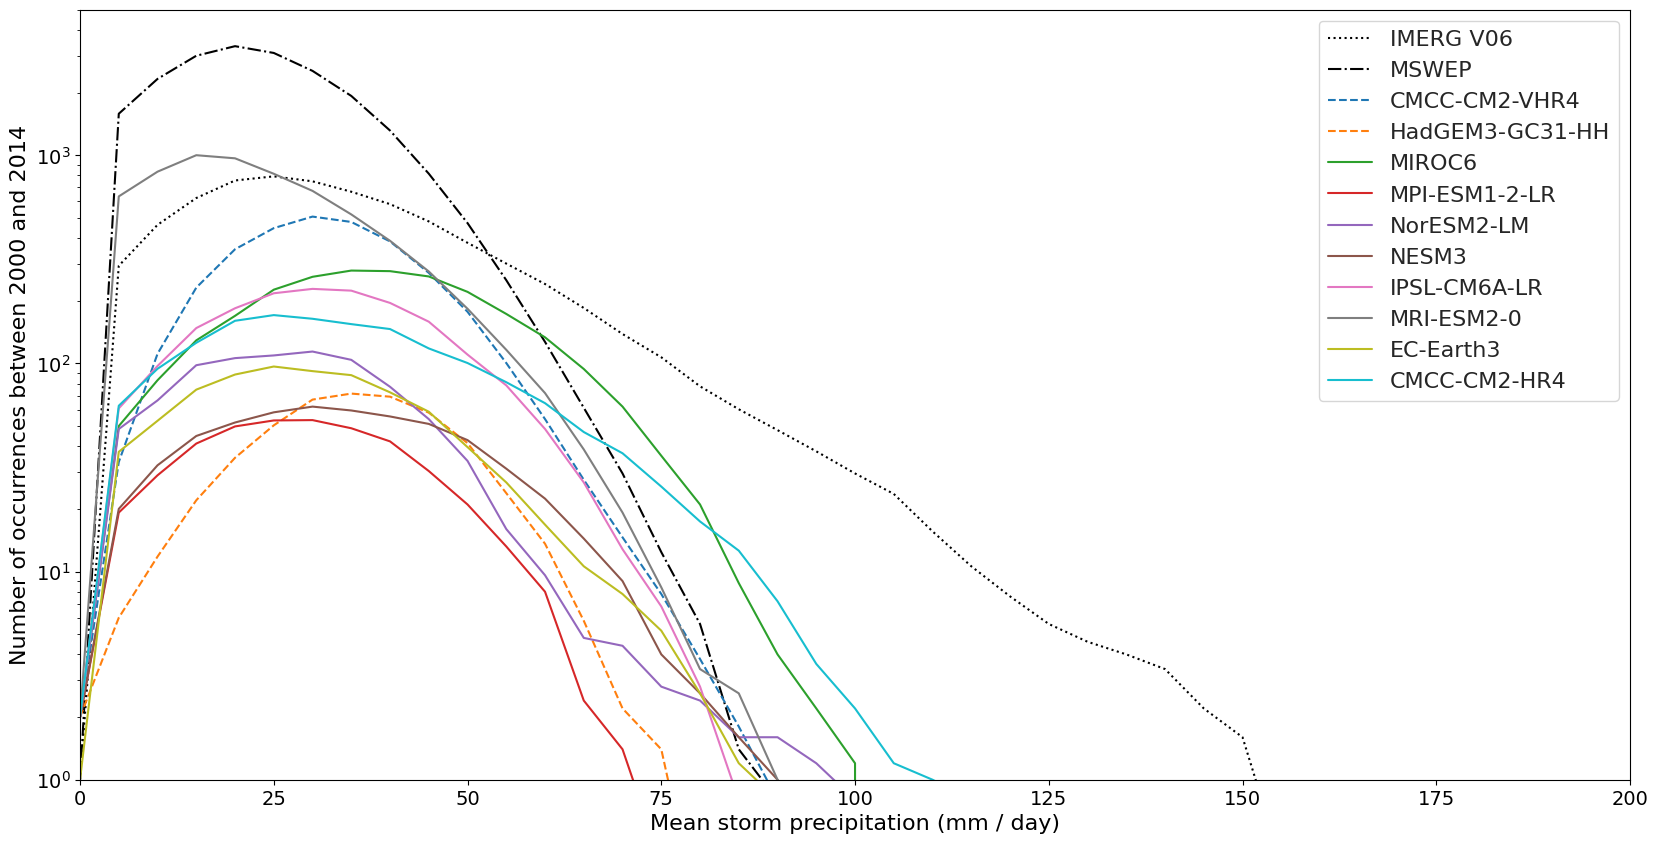

In [16]:
# TODO: subsample so all counts are equivalent to 6 hourly samples - it will skew results if mswep is 3 hourly and cmip6 is a mix of 3 and 6 hourly.
fig,axes = plt.subplots(1,1,figsize=(20, 10))
sns.set(style="whitegrid")
sns.set_palette("Set2")

# plt.plot(dates_wgan,total_rain_wgan,linestyle='dashed')
# plt.plot(dates_wgan_og,total_rain_wgan_og,linestyle='dashed')

# Obs
plt.plot(dates_imerg,total_rain_imerg,color='black',linestyle='dotted')
plt.plot(dates_mswep,total_rain_mswep,color='black',linestyle='dashdot')


# HighresMIP
im = axes.plot(dates_CMCC_nh,total_rain_CMCC_nh+total_rain_CMCC_sh,linestyle='dashed')
np.save('data/dates_CMCC.npy',dates_CMCC_nh)
np.save('data/total_rain_CMCC.npy',total_rain_CMCC_nh+total_rain_CMCC_sh)

# axes.plot(dates_CMCC_sh,total_rain_CMCC_sh)

axes.plot(dates_hadgem_nh,total_rain_hadgem_nh + total_rain_hadgem_sh,linestyle='dashed')
np.save('data/dates_hadgem.npy',dates_hadgem_nh)
np.save('data/total_rain_hadgem.npy',total_rain_hadgem_nh + total_rain_hadgem_sh)
# axes.plot(dates_ecearth_nh,total_rain_ecearthhr_nh)
# axes.plot(dates_ecearth_sh,total_rain_ecearthhr_sh)

# CMIP6 hist
axes.plot(dates_miroc6_nh, total_rain_miroc6_nh + total_rain_miroc6_sh)
np.save('data/dates_miroc6.npy',dates_miroc6_nh)
np.save('data/total_rain_miroc6.npy',total_rain_miroc6_nh + total_rain_miroc6_sh)
# axes.plot(dates_miroc6_sh, total_rain_miroc6_sh)

axes.plot(dates_mpi_nh, total_rain_mpi_nh + total_rain_mpi_sh)
np.save('data/dates_mpi.npy',dates_mpi_nh)
np.save('data/total_rain_mpi.npy',total_rain_mpi_nh + total_rain_mpi_sh)
# axes.plot(dates_mpi_sh,total_rain_mpi_sh)

axes.plot(dates_noresm_nh,total_rain_noresm_nh + total_rain_noresm_nh)
np.save('data/dates_noresm.npy',dates_noresm_nh)
np.save('data/total_rain_noresm.npy',total_rain_noresm_nh + total_rain_noresm_nh)
# im_8c = axes[5,1].plot(total_rain_noresm_sh)

axes.plot(dates_nesm_nh, total_rain_nesm_nh + total_rain_nesm_sh)
np.save('data/dates_nesm.npy',dates_nesm_nh)
np.save('data/total_rain_nesm.npy',total_rain_nesm_nh + total_rain_nesm_sh)
# axes.plot(dates_nesm_sh, total_rain_nesm_sh)

axes.plot(dates_ipsl_nh, total_rain_ipsl_nh +total_rain_ipsl_sh)
np.save('data/dates_ipsl.npy',dates_ipsl_nh)
np.save('data/total_rain_ipsl.npy',total_rain_ipsl_nh +total_rain_ipsl_sh)
# axes.plot(dates_ipsl_sh, total_rain_ipsl_sh)

axes.plot(dates_mri_nh, total_rain_mri_nh + total_rain_mri_sh)
np.save('data/dates_mri.npy',dates_mri_nh)
np.save('data/total_rain_mri.npy',total_rain_mri_nh + total_rain_mri_sh)
# axes.plot(dates_mri_sh, total_rain_mri_sh)

axes.plot(dates_ecearth_nh, total_rain_ecearth_nh)
np.save('data/dates_ecearth.npy',dates_ecearth_nh)
np.save('data/total_rain_ecearth.npy',total_rain_ecearth_nh)
# axes[7,1].plot(dates_ecearth_sh, total_rain_ecearth_sh)

axes.plot(dates_cmcclr_nh, total_rain_cmcclr_nh + total_rain_cmcclr_sh)
np.save('data/dates_cmcclr.npy',dates_cmcclr_nh)
np.save('data/total_rain_cmcclr.npy',total_rain_cmcclr_nh + total_rain_cmcclr_sh)
# axes.plot(dates_cmcclr_sh, total_rain_cmcclr_sh)




plt.yscale('log')
plt.ylim(1,5000)
plt.xlim(0,200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['IMERG V06','MSWEP','CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'],fontsize=16)
plt.xlabel('Mean storm precipitation (mm / day)',fontsize=16)
plt.ylabel('Number of occurrences between 2000 and 2014',fontsize=16)

plt.savefig('3_rain_frequency_hist_2.png',bbox_inches='tight')

In [17]:
# load HighResMIP CMCC-CM2-VHR4 ssp585orical NH
CMCC_ssp585_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_rain_NH.npy')
CMCC_ssp585_NH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_lats_NH.npy')
CMCC_ssp585_NH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_lons_NH.npy')
CMCC_ssp585_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_sid_NH.csv')
print(CMCC_ssp585_NH_sids.sid.shape)
indices = (CMCC_ssp585_NH_sids['year'] >= 2035) & (CMCC_ssp585_NH_sids['year'] <= 2049)
CMCC_ssp585_NH_sids = CMCC_ssp585_NH_sids[indices].reset_index()
CMCC_ssp585_NH_rain = CMCC_ssp585_NH_rain[indices]
CMCC_ssp585_NH_lats = CMCC_ssp585_NH_lats[indices]
CMCC_ssp585_NH_lons = CMCC_ssp585_NH_lons[indices]
meta_CMCC_ssp585_NH = pd.DataFrame({'sid':CMCC_ssp585_NH_sids.sid ,'centre_lat':CMCC_ssp585_NH_lats[:,4], 'centre_lon':CMCC_ssp585_NH_lons[:,4], 'date':find_dates(CMCC_ssp585_NH_sids,'365_day','highresmip'), 'hour':CMCC_ssp585_NH_sids.hour})

# load HighResMIP CMCC-CM2-VHR4 ssp585 SH
CMCC_ssp585_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_rain_SH.npy')
CMCC_ssp585_SH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_lats_SH.npy')
CMCC_ssp585_SH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_lons_SH.npy')
CMCC_ssp585_SH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/ssp585/storm_sid_SH.csv')
print(CMCC_ssp585_SH_sids.sid.shape)
indices = (CMCC_ssp585_SH_sids['year'] >= 2035) & (CMCC_ssp585_SH_sids['year'] <= 2049)
CMCC_ssp585_SH_sids = CMCC_ssp585_SH_sids[indices].reset_index()
CMCC_ssp585_SH_rain = CMCC_ssp585_SH_rain[indices]
CMCC_ssp585_SH_lats = CMCC_ssp585_SH_lats[indices]
CMCC_ssp585_SH_lons = CMCC_ssp585_SH_lons[indices]
meta_CMCC_ssp585_SH = pd.DataFrame({'sid':CMCC_ssp585_SH_sids.sid ,'centre_lat':CMCC_ssp585_SH_lats[:,4], 'centre_lon':CMCC_ssp585_SH_lons[:,4], 'date':find_dates(CMCC_ssp585_SH_sids,'365_day','highresmip'), 'hour':CMCC_ssp585_SH_sids.hour})

# load HighResMIP EC-EARTH-3P-HR  ssp585 NH
ecearthhr_ssp585_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_rain_NH.npy')
ecearthhr_ssp585_NH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_lats_NH.npy')
ecearthhr_ssp585_NH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_lons_NH.npy')
ecearthhr_ssp585_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_sid_NH.csv')
print(ecearthhr_ssp585_NH_sids.sid.shape)
indices = (ecearthhr_ssp585_NH_sids['year'] >= 2035) & (ecearthhr_ssp585_NH_sids['year'] <= 2049)
ecearthhr_ssp585_NH_sids = ecearthhr_ssp585_NH_sids[indices].reset_index()
ecearthhr_ssp585_NH_rain = ecearthhr_ssp585_NH_rain[indices]
ecearthhr_ssp585_NH_lats = ecearthhr_ssp585_NH_lats[indices]
ecearthhr_ssp585_NH_lons = ecearthhr_ssp585_NH_lons[indices]
meta_ecearthhr_ssp585_NH = pd.DataFrame({'sid':ecearthhr_ssp585_NH_sids.sid ,'centre_lat':ecearthhr_ssp585_NH_lats[:,4], 'centre_lon':ecearthhr_ssp585_NH_lons[:,4], 'year':ecearthhr_ssp585_NH_sids.year, 'hour':ecearthhr_ssp585_NH_sids.hour})

# load HighResMIP EC-EARTH-3P-HR ssp585 SH
ecearthhr_ssp585_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_rain_SH.npy')
ecearthhr_ssp585_SH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_lats_SH.npy')
ecearthhr_ssp585_SH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_lons_SH.npy')
ecearthhr_ssp585_SH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/ssp585/storm_sid_SH.csv')
print(ecearthhr_ssp585_SH_sids.sid.shape)
indices = (ecearthhr_ssp585_SH_sids['year'] >= 2035) & (ecearthhr_ssp585_SH_sids['year'] <= 2049)
ecearthhr_ssp585_SH_sids = ecearthhr_ssp585_SH_sids[indices].reset_index()
ecearthhr_ssp585_SH_rain = ecearthhr_ssp585_SH_rain[indices]
ecearthhr_ssp585_SH_lats = ecearthhr_ssp585_SH_lats[indices]
ecearthhr_ssp585_SH_lons = ecearthhr_ssp585_SH_lons[indices]
meta_ecearthhr_ssp585_SH = pd.DataFrame({'sid':ecearthhr_ssp585_SH_sids.sid ,'centre_lat':ecearthhr_ssp585_SH_lats[:,4], 'centre_lon':ecearthhr_ssp585_SH_lons[:,4], 'year':ecearthhr_ssp585_SH_sids.year, 'hour':ecearthhr_ssp585_SH_sids.hour})

# load HighResMIP HadGEM3-GC31-HM   ssp585 NH
hadgem_ssp585_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_rain_NH.npy')
hadgem_ssp585_NH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_lats_NH.npy')
hadgem_ssp585_NH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_lons_NH.npy')
hadgem_ssp585_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_sid_NH.csv')
print(hadgem_ssp585_NH_sids.sid.shape)
indices = (hadgem_ssp585_NH_sids['year'] >= 2035) & (hadgem_ssp585_NH_sids['year'] <= 2049)
hadgem_ssp585_NH_sids = hadgem_ssp585_NH_sids[indices].reset_index()
hadgem_ssp585_NH_rain = hadgem_ssp585_NH_rain[indices]
hadgem_ssp585_NH_lats = hadgem_ssp585_NH_lats[indices]
hadgem_ssp585_NH_lons = hadgem_ssp585_NH_lons[indices]
meta_hadgem_ssp585_NH = pd.DataFrame({'sid':hadgem_ssp585_NH_sids.sid ,'centre_lat':hadgem_ssp585_NH_lats[:,4], 'centre_lon':hadgem_ssp585_NH_lons[:,4],'date':find_dates(hadgem_ssp585_NH_sids,'360_day','highresmip'), 'hour':hadgem_ssp585_NH_sids.hour})

# # load HighResMIP HadGEM3-GC31-HM  ssp585 SH
hadgem_ssp585_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_rain_SH.npy')
hadgem_ssp585_SH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_lats_SH.npy')
hadgem_ssp585_SH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_lons_SH.npy')
hadgem_ssp585_SH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/ssp585/storm_sid_SH.csv')
print(hadgem_ssp585_SH_sids.sid.shape)
indices = (hadgem_ssp585_SH_sids['year'] >= 2035) & (hadgem_ssp585_SH_sids['year'] <= 2049)
hadgem_ssp585_SH_sids = hadgem_ssp585_SH_sids[indices].reset_index()
hadgem_ssp585_SH_rain = hadgem_ssp585_SH_rain[indices]
hadgem_ssp585_SH_lats = hadgem_ssp585_SH_lats[indices]
hadgem_ssp585_SH_lons = hadgem_ssp585_SH_lons[indices]
meta_hadgem_ssp585_SH = pd.DataFrame({'sid':hadgem_ssp585_SH_sids.sid ,'centre_lat':hadgem_ssp585_SH_lats[:,4], 'centre_lon':hadgem_ssp585_SH_lons[:,4], 'date':find_dates(hadgem_ssp585_SH_sids,'360_day','highresmip'), 'hour':hadgem_ssp585_SH_sids.hour})


(5756,)
(2484,)
(153,)
(33,)
(1042,)
(197,)


In [18]:
# load CMIP6 future dataset 
miroc6_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_rain_NH.npy')
miroc6_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_lats_NH.npy')
miroc6_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_lons_NH.npy')
miroc6_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_sid_NH.csv')
indices = (miroc6_ssp585_sids['year'] >= 2085) & (miroc6_ssp585_sids['year'] <= 2099)
miroc6_ssp585_sids = miroc6_ssp585_sids[indices].reset_index()
miroc6_ssp585_rain = miroc6_ssp585_rain[indices]
miroc6_ssp585_lats = miroc6_ssp585_lats[indices]
miroc6_ssp585_lons = miroc6_ssp585_lons[indices]
meta_miroc6_ssp585 = pd.DataFrame({'sid':miroc6_ssp585_sids.sid ,'centre_lat':miroc6_ssp585_lats[:,4], 'centre_lon':miroc6_ssp585_lons[:,4], 'date':find_dates(miroc6_ssp585_sids,'gregorian',True), 'hour':miroc6_ssp585_sids.hour})

miroc6_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_rain_SH.npy')
miroc6_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_lats_SH.npy')
miroc6_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_lons_SH.npy')
miroc6_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/ssp585/storm_sid_SH.csv')
indices = (miroc6_ssp585_sids_SH['year'] >= 2085) & (miroc6_ssp585_sids_SH['year'] <= 2099)
miroc6_ssp585_sids_SH = miroc6_ssp585_sids_SH[indices].reset_index()
miroc6_ssp585_rain_SH = miroc6_ssp585_rain_SH[indices]
miroc6_ssp585_lats_SH = miroc6_ssp585_lats_SH[indices]
miroc6_ssp585_lons_SH = miroc6_ssp585_lons_SH[indices]
meta_miroc6_ssp585_SH = pd.DataFrame({'sid':miroc6_ssp585_sids_SH.sid ,'centre_lat':miroc6_ssp585_lats_SH[:,4], 'centre_lon':miroc6_ssp585_lons_SH[:,4], 'date':find_dates(miroc6_ssp585_sids_SH,'gregorian',True), 'hour':miroc6_ssp585_sids_SH.hour})

# CMIP6 MPI-ESM1-2-LR
mpi_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_rain_NH.npy')
mpi_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_lats_NH.npy')
mpi_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_lons_NH.npy')
mpi_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_sid_NH.csv')
indices = (mpi_ssp585_sids['year'] >= 2085) & (mpi_ssp585_sids['year'] <= 2099)
mpi_ssp585_sids = mpi_ssp585_sids[indices].reset_index()
mpi_ssp585_rain = mpi_ssp585_rain[indices]
mpi_ssp585_lats = mpi_ssp585_lats[indices]
mpi_ssp585_lons = mpi_ssp585_lons[indices]
meta_mpi_ssp585 = pd.DataFrame({'sid':mpi_ssp585_sids.sid ,'centre_lat':mpi_ssp585_lats[:,4], 'centre_lon':mpi_ssp585_lons[:,4], 'date':find_dates(mpi_ssp585_sids,'proleptic_gregorian',True), 'hour':mpi_ssp585_sids.hour})

mpi_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_rain_SH.npy')
mpi_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_lats_SH.npy')
mpi_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_lons_SH.npy')
mpi_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/ssp585/storm_sid_SH.csv')
indices = (mpi_ssp585_sids_SH['year'] >= 2085) & (mpi_ssp585_sids_SH['year'] <= 2099)
mpi_ssp585_sids_SH = mpi_ssp585_sids_SH[indices].reset_index()
mpi_ssp585_rain_SH = mpi_ssp585_rain_SH[indices]
mpi_ssp585_lats_SH = mpi_ssp585_lats_SH[indices]
mpi_ssp585_lons_SH = mpi_ssp585_lons_SH[indices]
meta_mpi_ssp585_SH = pd.DataFrame({'sid':mpi_ssp585_sids_SH.sid ,'centre_lat':mpi_ssp585_lats_SH[:,4], 'centre_lon':mpi_ssp585_lons_SH[:,4], 'date':find_dates(mpi_ssp585_sids_SH,'proleptic_gregorian',True), 'hour':mpi_ssp585_sids_SH.hour})

# CMIP6 Noresm
noresm_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_rain_NH.npy')
noresm_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_lats_NH.npy')
noresm_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_lons_NH.npy')
noresm_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_sid_NH.csv')
indices = (noresm_ssp585_sids['year'] >= 2085) & (noresm_ssp585_sids['year'] <= 2099)
noresm_ssp585_sids = noresm_ssp585_sids[indices].reset_index()
noresm_ssp585_rain = noresm_ssp585_rain[indices]
noresm_ssp585_lats = noresm_ssp585_lats[indices]
noresm_ssp585_lons = noresm_ssp585_lons[indices]
meta_noresm_ssp585 = pd.DataFrame({'sid':noresm_ssp585_sids.sid ,'centre_lat':noresm_ssp585_lats[:,4], 'centre_lon':noresm_ssp585_lons[:,4], 'date':find_dates(noresm_ssp585_sids,'noleap',True), 'hour':noresm_ssp585_sids.hour})

noresm_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_rain_SH.npy')
noresm_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_lats_SH.npy')
noresm_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_lons_SH.npy')
noresm_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/ssp585/storm_sid_SH.csv')
indices = (noresm_ssp585_sids_SH['year'] >= 2085) & (noresm_ssp585_sids_SH['year'] <= 2099)
noresm_ssp585_sids_SH = noresm_ssp585_sids_SH[indices].reset_index()
noresm_ssp585_rain_SH = noresm_ssp585_rain_SH[indices]
noresm_ssp585_lats_SH = noresm_ssp585_lats_SH[indices]
noresm_ssp585_lons_SH = noresm_ssp585_lons_SH[indices]
meta_noresm_ssp585_SH = pd.DataFrame({'sid':noresm_ssp585_sids_SH.sid ,'centre_lat':noresm_ssp585_lats_SH[:,4], 'centre_lon':noresm_ssp585_lons_SH[:,4], 'date':find_dates(noresm_ssp585_sids_SH,'noleap',True), 'hour':noresm_ssp585_sids_SH.hour})

# CMIP6 IPSL
ipsl_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_rain_NH.npy')
ipsl_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_lats_NH.npy')
ipsl_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_lons_NH.npy')
ipsl_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_sid_NH.csv')
indices = (ipsl_ssp585_sids['year'] >= 2085) & (ipsl_ssp585_sids['year'] <= 2099)
ipsl_ssp585_sids = ipsl_ssp585_sids[indices].reset_index()
ipsl_ssp585_rain = ipsl_ssp585_rain[indices]
ipsl_ssp585_lats = ipsl_ssp585_lats[indices]
ipsl_ssp585_lons = ipsl_ssp585_lons[indices]
meta_ipsl_ssp585 = pd.DataFrame({'sid':ipsl_ssp585_sids.sid ,'centre_lat':ipsl_ssp585_lats[:,4], 'centre_lon':ipsl_ssp585_lons[:,4], 'date':find_dates(ipsl_ssp585_sids,'gregorian',True), 'hour':ipsl_ssp585_sids.hour})

ipsl_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_rain_SH.npy')
ipsl_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_lats_SH.npy')
ipsl_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_lons_SH.npy')
ipsl_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/ssp585/storm_sid_SH.csv')
indices = (ipsl_ssp585_sids_SH['year'] >= 2085) & (ipsl_ssp585_sids_SH['year'] <= 2099)
ipsl_ssp585_sids_SH = ipsl_ssp585_sids_SH[indices].reset_index()
ipsl_ssp585_rain_SH = ipsl_ssp585_rain_SH[indices]
ipsl_ssp585_lats_SH = ipsl_ssp585_lats_SH[indices]
ipsl_ssp585_lons_SH = ipsl_ssp585_lons_SH[indices]
meta_ipsl_ssp585_SH = pd.DataFrame({'sid':ipsl_ssp585_sids_SH.sid ,'centre_lat':ipsl_ssp585_lats_SH[:,4], 'centre_lon':ipsl_ssp585_lons_SH[:,4], 'date':find_dates(ipsl_ssp585_sids_SH,'gregorian',True), 'hour':ipsl_ssp585_sids_SH.hour})

# CMIP6 mri
mri_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_rain_NH.npy')
mri_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_lats_NH.npy')
mri_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_lons_NH.npy')
mri_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_sid_NH.csv')
indices = (mri_ssp585_sids['year'] >= 2085) & (mri_ssp585_sids['year'] <= 2099)
mri_ssp585_sids = mri_ssp585_sids[indices].reset_index()
mri_ssp585_rain = mri_ssp585_rain[indices]
mri_ssp585_lats = mri_ssp585_lats[indices]
mri_ssp585_lons = mri_ssp585_lons[indices]
meta_mri_ssp585 = pd.DataFrame({'sid':mri_ssp585_sids.sid ,'centre_lat':mri_ssp585_lats[:,4], 'centre_lon':mri_ssp585_lons[:,4], 'date':find_dates(mri_ssp585_sids,'proleptic_gregorian',True), 'hour':mri_ssp585_sids.hour})

mri_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_rain_SH.npy')
mri_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_lats_SH.npy')
mri_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_lons_SH.npy')
mri_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/ssp585/storm_sid_SH.csv')
indices = (mri_ssp585_sids_SH['year'] >= 2085) & (mri_ssp585_sids_SH['year'] <= 2099)
mri_ssp585_sids_SH = mri_ssp585_sids_SH[indices].reset_index()
mri_ssp585_rain_SH = mri_ssp585_rain_SH[indices]
mri_ssp585_lats_SH = mri_ssp585_lats_SH[indices]
mri_ssp585_lons_SH = mri_ssp585_lons_SH[indices]
meta_mri_ssp585_SH = pd.DataFrame({'sid':mri_ssp585_sids_SH.sid ,'centre_lat':mri_ssp585_lats_SH[:,4], 'centre_lon':mri_ssp585_lons_SH[:,4], 'date':find_dates(mri_ssp585_sids_SH,'proleptic_gregorian',True), 'hour':mri_ssp585_sids_SH.hour})

# CMIP6 EC-Earth
ecearth_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_rain_NH.npy')
ecearth_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_lats_NH.npy')
ecearth_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_lons_NH.npy')
ecearth_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_sid_NH.csv')
indices = (ecearth_ssp585_sids['year'] >= 2085) & (ecearth_ssp585_sids['year'] <= 2099)
ecearth_ssp585_sids = ecearth_ssp585_sids[indices].reset_index()
ecearth_ssp585_rain = ecearth_ssp585_rain[indices]
ecearth_ssp585_lats = ecearth_ssp585_lats[indices]
ecearth_ssp585_lons = ecearth_ssp585_lons[indices]
meta_ecearth_ssp585 = pd.DataFrame({'sid':ecearth_ssp585_sids.sid ,'centre_lat':ecearth_ssp585_lats[:,4], 'centre_lon':ecearth_ssp585_lons[:,4], 'date':find_dates(ecearth_ssp585_sids,'proleptic_gregorian',True), 'hour':ecearth_ssp585_sids.hour})

ecearth_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_rain_SH.npy')
ecearth_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_lats_SH.npy')
ecearth_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_lons_SH.npy')
ecearth_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/ssp585/storm_sid_SH.csv')
indices = (ecearth_ssp585_sids_SH['year'] >= 2085) & (ecearth_ssp585_sids_SH['year'] <= 2099)
ecearth_ssp585_sids_SH = ecearth_ssp585_sids_SH[indices].reset_index()
ecearth_ssp585_rain_SH = ecearth_ssp585_rain_SH[indices]
ecearth_ssp585_lats_SH = ecearth_ssp585_lats_SH[indices]
ecearth_ssp585_lons_SH = ecearth_ssp585_lons_SH[indices]
meta_ecearth_ssp585_SH = pd.DataFrame({'sid':ecearth_ssp585_sids_SH.sid ,'centre_lat':ecearth_ssp585_lats_SH[:,4], 'centre_lon':ecearth_ssp585_lons_SH[:,4], 'date':find_dates(ecearth_ssp585_sids_SH,'proleptic_gregorian',True), 'hour':ecearth_ssp585_sids_SH.hour})

# CMIP6 CMCC_LR
cmcclr_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_rain_NH.npy')
cmcclr_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_lats_NH.npy')
cmcclr_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_lons_NH.npy')
cmcclr_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_sid_NH.csv')
indices = (cmcclr_ssp585_sids['year'] >= 2085) & (cmcclr_ssp585_sids['year'] <= 2099)
cmcclr_ssp585_sids = cmcclr_ssp585_sids[indices].reset_index()
cmcclr_ssp585_rain = cmcclr_ssp585_rain[indices]
cmcclr_ssp585_lats = cmcclr_ssp585_lats[indices]
cmcclr_ssp585_lons = cmcclr_ssp585_lons[indices]
meta_cmcclr_ssp585 = pd.DataFrame({'sid':cmcclr_ssp585_sids.sid ,'centre_lat':cmcclr_ssp585_lats[:,4], 'centre_lon':cmcclr_ssp585_lons[:,4], 'date':find_dates(cmcclr_ssp585_sids,'365_day',True), 'hour':cmcclr_ssp585_sids.hour})

cmcclr_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_rain_SH.npy')
cmcclr_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_lats_SH.npy')
cmcclr_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_lons_SH.npy')
cmcclr_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/ssp585/storm_sid_SH.csv')
indices = (cmcclr_ssp585_sids_SH['year'] >= 2085) & (cmcclr_ssp585_sids_SH['year'] <= 2099)
cmcclr_ssp585_sids_SH = cmcclr_ssp585_sids_SH[indices].reset_index()
cmcclr_ssp585_rain_SH = cmcclr_ssp585_rain_SH[indices]
cmcclr_ssp585_lats_SH = cmcclr_ssp585_lats_SH[indices]
cmcclr_ssp585_lons_SH = cmcclr_ssp585_lons_SH[indices]
meta_cmcclr_ssp585_SH = pd.DataFrame({'sid':cmcclr_ssp585_sids_SH.sid ,'centre_lat':cmcclr_ssp585_lats_SH[:,4], 'centre_lon':cmcclr_ssp585_lons_SH[:,4], 'date':find_dates(cmcclr_ssp585_sids_SH,'365_day',True), 'hour':cmcclr_ssp585_sids_SH.hour})

# CMIP6 NESM3
nesm_ssp585_rain = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_rain_NH.npy')
nesm_ssp585_lats = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_lats_NH.npy')
nesm_ssp585_lons = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_lons_NH.npy')
nesm_ssp585_sids = pd.read_csv('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_sid_NH.csv')
indices = (nesm_ssp585_sids['year'] >= 2085) & (nesm_ssp585_sids['year'] <= 2099)
nesm_ssp585_sids = nesm_ssp585_sids[indices].reset_index()
nesm_ssp585_rain = nesm_ssp585_rain[indices]
nesm_ssp585_lats = nesm_ssp585_lats[indices]
nesm_ssp585_lons = nesm_ssp585_lons[indices]
meta_nesm_ssp585 = pd.DataFrame({'sid':nesm_ssp585_sids.sid ,'centre_lat':nesm_ssp585_lats[:,4], 'centre_lon':nesm_ssp585_lons[:,4], 'date':find_dates(nesm_ssp585_sids,'standard',True), 'hour':nesm_ssp585_sids.hour})

nesm_ssp585_rain_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_rain_SH.npy')
nesm_ssp585_lats_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_lats_SH.npy')
nesm_ssp585_lons_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_lons_SH.npy')
nesm_ssp585_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/NESM3/storm_rain/ssp585/storm_sid_SH.csv')
indices = (nesm_ssp585_sids_SH['year'] >= 2085) & (nesm_ssp585_sids_SH['year'] <= 2099)
nesm_ssp585_sids_SH = nesm_ssp585_sids_SH[indices].reset_index()
nesm_ssp585_rain_SH = nesm_ssp585_rain_SH[indices]
nesm_ssp585_lats_SH = nesm_ssp585_lats_SH[indices]
nesm_ssp585_lons_SH = nesm_ssp585_lons_SH[indices]
meta_nesm_ssp585_SH = pd.DataFrame({'sid':nesm_ssp585_sids_SH.sid ,'centre_lat':nesm_ssp585_lats_SH[:,4], 'centre_lon':nesm_ssp585_lons_SH[:,4], 'date':find_dates(nesm_ssp585_sids_SH,'standard',True), 'hour':nesm_ssp585_sids_SH.hour})



In [19]:


cmip_converter = 4

# HighResMIP
total_rain_CMCC_nh,dates_CMCC_nh = generate_annual_frequency(meta_CMCC_ssp585_NH,np.expand_dims(CMCC_ssp585_NH_rain,axis=-1),cmip_converter,future=True)
total_rain_CMCC_sh,dates_CMCC_sh = generate_annual_frequency(meta_CMCC_ssp585_SH,np.expand_dims(CMCC_ssp585_SH_rain,axis=-1),cmip_converter,future=True)



total_rain_hadgem_nh,dates_hadgem_nh = generate_annual_frequency(meta_hadgem_ssp585_NH,np.expand_dims(hadgem_ssp585_NH_rain,axis=-1),cmip_converter,future=True)
total_rain_hadgem_sh,dates_hadgem_sh = generate_annual_frequency(meta_hadgem_ssp585_SH,np.expand_dims(hadgem_ssp585_SH_rain,axis=-1),cmip_converter,future=True)


# CMIP6
total_rain_miroc6_nh,dates_miroc6_nh = generate_annual_frequency(meta_miroc6_ssp585,np.expand_dims(miroc6_ssp585_rain,axis=-1),cmip_converter,future=True)
total_rain_miroc6_sh,dates_miroc6_sh = generate_annual_frequency(meta_miroc6_ssp585_SH,np.expand_dims(miroc6_ssp585_rain_SH,axis=-1),cmip_converter,future=True)

total_rain_mpi_nh,dates_mpi_nh = generate_annual_frequency(meta_mpi_ssp585,np.expand_dims(mpi_ssp585_rain,axis=-1),cmip_converter,future=True)
total_rain_mpi_sh,dates_mpi_sh = generate_annual_frequency(meta_mpi_ssp585_SH,np.expand_dims(mpi_ssp585_rain_SH,axis=-1),cmip_converter,future=True)

total_rain_noresm_nh,dates_noresm_nh = generate_annual_frequency(meta_noresm_ssp585,np.expand_dims(noresm_ssp585_rain,axis=-1),cmip_converter,future=True)
total_rain_noresm_nh,dates_noresm_nh = generate_annual_frequency(meta_noresm_ssp585_SH,np.expand_dims(noresm_ssp585_rain_SH,axis=-1),cmip_converter,future=True)

total_rain_nesm_nh,dates_nesm_nh = generate_annual_frequency(meta_nesm_ssp585,np.expand_dims(nesm_ssp585_rain,axis=-1),cmip_converter,future=True)
total_rain_nesm_sh,dates_nesm_sh = generate_annual_frequency(meta_nesm_ssp585_SH,np.expand_dims(nesm_ssp585_rain_SH,axis=-1),cmip_converter,future=True)

total_rain_ipsl_nh,dates_ipsl_nh = generate_annual_frequency(meta_ipsl_ssp585,np.expand_dims(ipsl_ssp585_rain,axis=-1),cmip_converter,future=True)
total_rain_ipsl_sh,dates_ipsl_sh = generate_annual_frequency(meta_ipsl_ssp585_SH,np.expand_dims(ipsl_ssp585_rain_SH,axis=-1),cmip_converter,future=True)

total_rain_mri_nh,dates_mri_nh = generate_annual_frequency(meta_mri_ssp585,np.expand_dims(mri_ssp585_rain,axis=-1),cmip_converter,future=True)
total_rain_mri_sh,dates_mri_sh  = generate_annual_frequency(meta_mri_ssp585_SH,np.expand_dims(mri_ssp585_rain_SH,axis=-1),cmip_converter,future=True)

total_rain_ecearth_nh,dates_ecearth_nh = generate_annual_frequency(meta_ecearth_ssp585,np.expand_dims(ecearth_ssp585_rain,axis=-1),cmip_converter,future=True)
total_rain_ecearth_sh,dates_ecearth_sh = generate_annual_frequency(meta_ecearth_ssp585_SH,np.expand_dims(ecearth_ssp585_rain_SH,axis=-1),cmip_converter,future=True)

total_rain_cmcclr_nh,dates_cmcclr_nh = generate_annual_frequency(meta_cmcclr_ssp585,np.expand_dims(cmcclr_ssp585_rain,axis=-1),cmip_converter,future=True)
total_rain_cmcclr_sh,dates_cmcclr_sh = generate_annual_frequency(meta_cmcclr_ssp585_SH,np.expand_dims(cmcclr_ssp585_rain_SH,axis=-1),cmip_converter,future=True)

0       2035-01-02 00:00:00
1       2035-01-03 00:00:00
2       2035-01-04 00:00:00
3       2035-01-04 00:00:00
4       2035-01-04 00:00:00
               ...         
2725                      0
2726                      0
2727                      0
2728                      0
2729                      0
Name: date, Length: 2730, dtype: object
bool (2433,)
number of timepoints =  (2402, 5)
sids unique (215,)
[  0   2   3 106 361 490 451 348 253 178 111  56  25  11   6   1   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
0       2035-03-03 00:00:00
1       2035-03-03 00:00:00
2       2035-03-03 00:00:00
3       2035-03-26 00:00:00
4       2035-03-28 00:00:00
               ...         
1046                      0
1047                      0
1048                      0
1049                      0
1050                      0
Name: date, Length: 1051, dtype: 

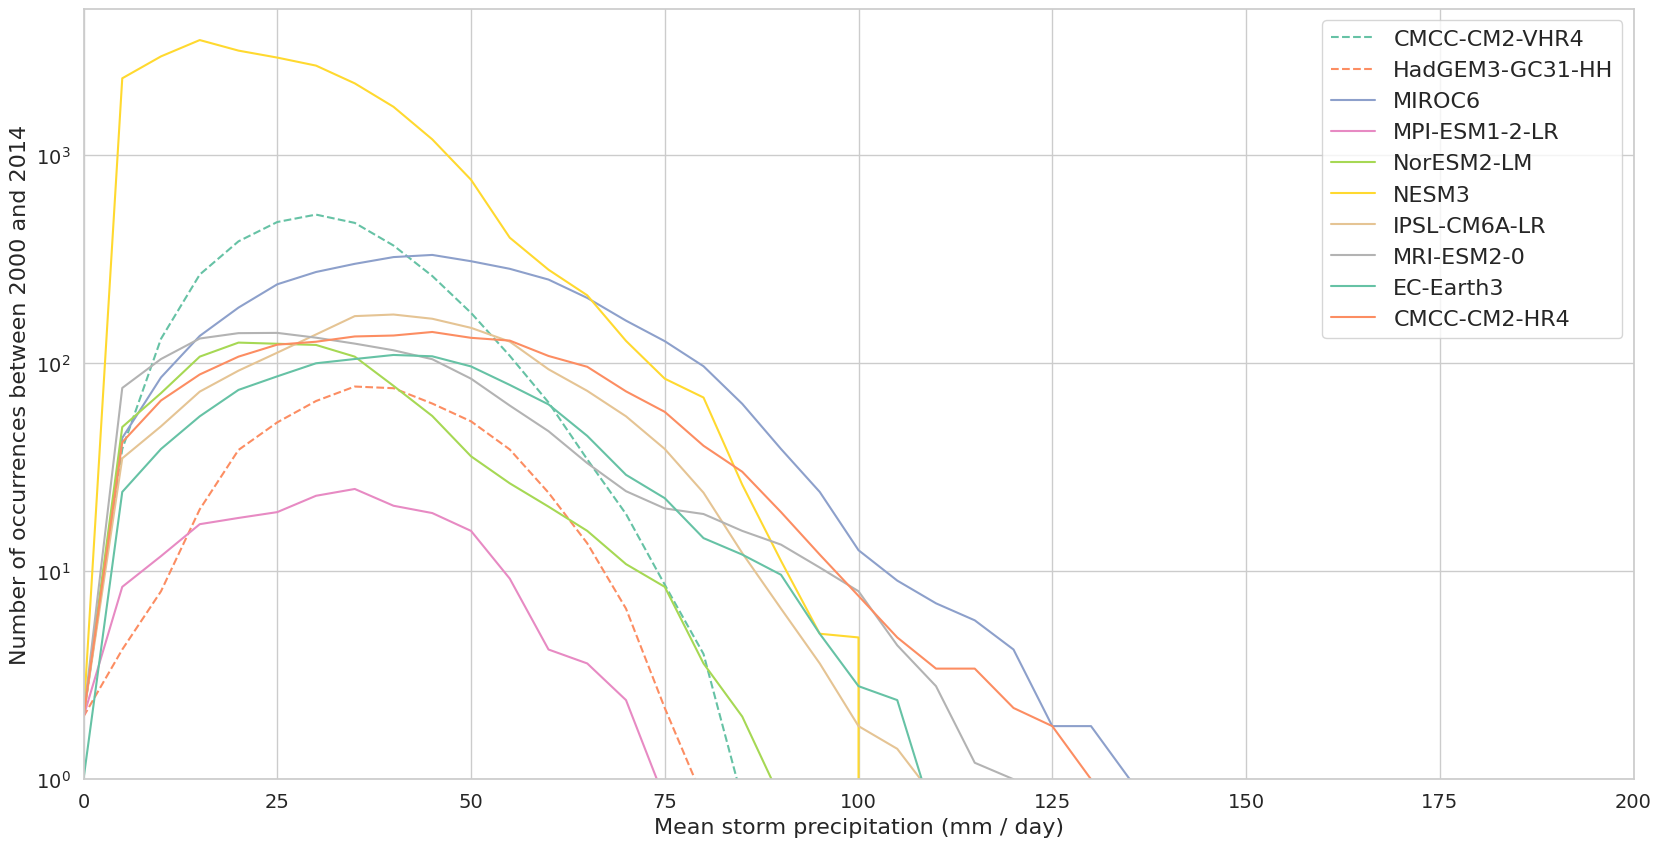

In [20]:
# TODO: subsample so all counts are equivalent to 6 hourly samples - it will skew results if mswep is 3 hourly and cmip6 is a mix of 3 and 6 hourly.
fig,axes = plt.subplots(1,1,figsize=(20, 10))
sns.set(style="whitegrid")
sns.set_palette("Set2")

# Obs
# plt.plot(dates_imerg,total_rain_imerg,color='black',linestyle='dotted')
# plt.plot(dates_mswep,total_rain_mswep,color='black',linestyle='dashdot')


# HighresMIP
im = axes.plot(dates_CMCC_nh,total_rain_CMCC_nh+total_rain_CMCC_sh,linestyle='dashed')
np.save('dates_CMCC_ssp585.npy',dates_CMCC_nh)
np.save('total_rain_CMCC_ssp585.npy',total_rain_CMCC_nh+total_rain_CMCC_sh)

axes.plot(dates_hadgem_nh,total_rain_hadgem_nh + total_rain_hadgem_sh,linestyle='dashed')
np.save('dates_hadgem_ssp585.npy',dates_hadgem_nh)
np.save('total_rain_hadgem_ssp585.npy',total_rain_hadgem_nh+total_rain_hadgem_sh)

# CMIP6 hist
axes.plot(dates_miroc6_nh, total_rain_miroc6_nh + total_rain_miroc6_sh)
np.save('dates_miroc6_ssp585.npy',dates_miroc6_nh)
np.save('total_rain_miroc6_ssp585.npy',total_rain_miroc6_nh + total_rain_miroc6_sh)

axes.plot(dates_mpi_nh, total_rain_mpi_nh + total_rain_mpi_sh)
np.save('dates_mpi_ssp585.npy',dates_mpi_nh)
np.save('total_rain_mpi_ssp585.npy',total_rain_mpi_nh + total_rain_mpi_sh)

axes.plot(dates_noresm_nh,total_rain_noresm_nh + total_rain_noresm_nh)
np.save('dates_noresm_ssp585.npy',dates_noresm_nh)
np.save('total_rain_noresm_ssp585.npy',total_rain_noresm_nh + total_rain_noresm_nh)

axes.plot(dates_nesm_nh, total_rain_nesm_nh + total_rain_nesm_sh)
np.save('dates_nesm_ssp585.npy',dates_nesm_nh)
np.save('total_rain_nesm_ssp585.npy',total_rain_nesm_nh + total_rain_nesm_sh)

axes.plot(dates_ipsl_nh, total_rain_ipsl_nh +total_rain_ipsl_sh)
np.save('dates_ipsl_ssp585.npy',dates_ipsl_nh)
np.save('total_rain_ipsl_ssp585.npy',total_rain_ipsl_nh +total_rain_ipsl_sh)

axes.plot(dates_mri_nh, total_rain_mri_nh + total_rain_mri_sh)
np.save('dates_mri_ssp585.npy',dates_mri_nh)
np.save('total_rain_mri_ssp585.npy',total_rain_mri_nh + total_rain_mri_sh)

axes.plot(dates_ecearth_nh, total_rain_ecearth_nh)
np.save('dates_ecearth_ssp585.npy',dates_ecearth_nh)
np.save('total_rain_ecearth_ssp585.npy',total_rain_ecearth_nh)

axes.plot(dates_cmcclr_nh, total_rain_cmcclr_nh + total_rain_cmcclr_sh)
np.save('dates_cmcclr_ssp585.npy',dates_cmcclr_nh)
np.save('total_rain_cmcclr_ssp585.npy',total_rain_cmcclr_nh + total_rain_cmcclr_sh)



plt.yscale('log')
plt.ylim(1,5000)
plt.xlim(0,200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'],fontsize=16)
plt.xlabel('Mean storm precipitation (mm / day)',fontsize=16)
plt.ylabel('Number of occurrences between 2000 and 2014',fontsize=16)

plt.savefig('3_rain_frequency_ssp585_2.png',bbox_inches='tight')